C:\Users\maitr\AppData\Local\Temp\ipykernel_17912\3631523010.py:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


Photospheric Bz (T): min, max, 99pct: -1.0707726149750976 1.0707726149750976 0.8474568904377487
Ring current I = 4088910006356.5396 A


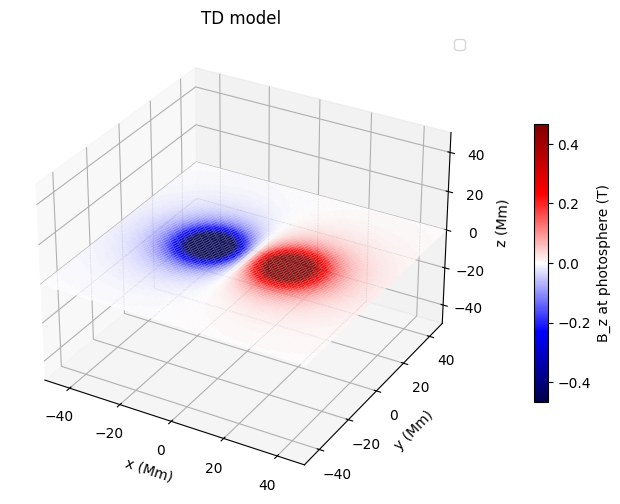

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from PIL import Image

# ---------------------------
# PARAMETERS
# ---------------------------
Mm = 1e6  # meters per Mm
domain_size_Mm = 100.0   # full cubic domain size in Mm (100 Mm each side)
N = 100                  # points per axis (100^3 points -> 1e6)
L = 30.0                 # Mm (used for charge x-position half-separation)
d = 10.0                 # Mm (depth under photosphere)
q_Mm2 = 1e2              # q in T·Mm^2 (102 -> 1e2)
# convert q to SI units T·m^2
q = q_Mm2 * (Mm**2)      # q in T·m^2

# ---------------------------
# GRID (in Mm, then convert to m)
# ---------------------------
# let x,y,z range from -domain/2 to +domain/2 so z=0 is inside grid
half = domain_size_Mm / 2.0
x = np.linspace(-half, half, N)  # Mm
y = np.linspace(-half, half, N)  # Mm
z = np.linspace(-half, half, N)  # Mm
X, Y = np.meshgrid(x, y, indexing='xy')  # for plotting plane at z=0

# For full 3D computation we create 3D coordinate arrays (in meters)
xx = x * Mm
yy = y * Mm
zz = z * Mm

# create 3D mesh (N=100 => 1e6 points)
X3, Y3, Z3 = np.meshgrid(xx, yy, zz, indexing='xy')  # shapes (N,N,N) in meters

# ---------------------------
# CHARGE POSITIONS (meters)
# ---------------------------
# place charges at x = +/- L/2 (Mm), y=0, z = -d (under photosphere)
xpos = (L / 2.0) * Mm
negpos = -xpos
ypos = 0.0
zcharge = -d * Mm  # under photosphere

r1_pos = np.array([xpos, ypos, zcharge])
r2_pos = np.array([negpos, ypos, zcharge])

# ---------------------------
# COMPUTE B FIELD (vectorized)
# B = q * (r - r0) / |r - r0|^3 --> r₀ = position of the charge, r = position of the point in space
# r0 = [x_charge, y_charge, z_charge] (source location), r = (X, Y, Z) = grid of field-point coordinates (observation point)
# ∣r−r0​∣^3 = r3 = [(x−x0​)^2+(y−y0​)^2+(z−z0​)^2]^3/2 --> 3/2=1.5
# ---------------------------
eps = 1e-9  # small softening to avoid division by zero (in meters)

def compute_B_from_charge(q, r0, X, Y, Z):
    rx = X - r0[0]     # --> (r - r0) [displacement vector]
    ry = Y - r0[1]
    rz = Z - r0[2]
    r3 = (rx**2 + ry**2 + rz**2) ** 1.5 + eps   # --> |r - r0|^3
    Bxq = q * rx / r3
    Byq = q * ry / r3
    Bzq = q * rz / r3
    return Bxq, Byq, Bzq

# compute B from both charges and sum
Bx1, By1, Bz1 = compute_B_from_charge(q, r1_pos, X3, Y3, Z3)
Bx2, By2, Bz2 = compute_B_from_charge(-q, r2_pos, X3, Y3, Z3)  # second charge opposite sign
# note: for a bipolar configuration we give second opposite sign (common for TD toy-model)
Bxq = Bx1 + Bx2
Byq = By1 + By2
Bzq = Bz1 + Bz2

# ---------------------------
# Extract photospheric plane (z=0).
# ---------------------------
z0_idx = np.argmin(np.abs(z * Mm - 0.0))
Bz_photos = Bzq[:, :, z0_idx]
Bx_photos = Bxq[:, :, z0_idx]
By_photos = Byq[:, :, z0_idx]

# convert X,Y for plotting in Mm
Xp = X  # grid in Mm
Yp = Y

# ---------------------------
# Plot Mangentogram
# ---------------------------
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# create surface for photosphere (z=0 plane)
Zplane = np.zeros_like(Xp)  # z=0 in Mm

# Normalize for colormap center at zero (diverging)
norm = Normalize(vmin=np.percentile(Bz_photos, 2), vmax=np.percentile(Bz_photos, 98))

# create facecolors from colormap using normalized Bz (we use 'seismic' to show +/-.)
cmap = plt.get_cmap('seismic')
facecolors = cmap(norm(Bz_photos))

# plot the photospheric plane as a colored surface (convert z in Mm to same units)
ax.plot_surface(Xp, Yp, Zplane, facecolors=facecolors, rstride=1, cstride=1, linewidth=0, antialiased=True, shade=False, alpha=0.95)

# axis labels (Mm)
ax.set_xlabel('x (Mm)')
ax.set_ylabel('y (Mm)')
ax.set_zlabel('z (Mm)')
ax.set_xlim(-half, half)
ax.set_ylim(-half, half)
ax.set_zlim(-half, half)

# colorbar for Bz (create a mappable)
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(Bz_photos)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('B_z at photosphere (T)')

ax.view_init(elev=30, azim=-60)  # (camera view)
ax.set_title('TD model')

# legend
ax.legend(loc='upper right')

# ---------------------------
# Print a quick check: max |Bz| on photosphere
# ---------------------------
print("Photospheric Bz (T): min, max, 99pct:", np.min(Bz_photos), np.max(Bz_photos),
      np.percentile(np.abs(Bz_photos), 99))

# -------------------------------
# calculation for ring current I
# -------------------------------

import numpy as np

def compute_ring_current(R_Mm, a_Mm, L_Mm, q_Mm2, li):
    Mm = 1e6
    mu0 = 4e-7 * np.pi  # permeability of free space

    # convert to meters
    R = R_Mm * Mm
    a = a_Mm * Mm
    L = L_Mm * Mm

    # q in T·m²
    q = q_Mm2 * (Mm**2)

    numerator = 8 * np.pi * q * L * R * (R**2 + L**2)**(-1.5)
    denominator = mu0 * (np.log(8 * R / a) - 1.5 + li / 2)

    I = numerator / denominator
    return I

# ---- call the function OUTSIDE the definition ----
I = compute_ring_current(R_Mm=20, a_Mm=2, L_Mm=50, q_Mm2=1e2, li=0.5)

print("Ring current I =", I, "A")


# -------------------------------
# calculation for Btheta
# -------------------------------

def compute_Btheta_TD(X, Y, Z, R_Mm, a_Mm, d_Mm, I0, I, chi=1.0):
    mu0 = 4e-7 * np.pi
    Mm = 1e6

    R = R_Mm * Mm
    a = a_Mm * Mm
    d = d_Mm * Mm

    r_perp = np.sqrt(Y**2 + (Z + d)**2)
    r_perp = np.where(r_perp == 0, 1e-9, r_perp)

    rho = np.sqrt(X**2 + (r_perp - R)**2)

    # theta-hat
    e_theta_x = np.zeros_like(X)
    e_theta_y = -(Z + d)/r_perp
    e_theta_z =  Y/r_perp

    # inner torus term (rho < a)
    term2 = np.where(rho < a, (2*chi*(a - rho)/a**2) * (I**2/I0**2) * (1 - rho**2/a**2), 0.0)

    B_inside = np.sqrt( 1.0/R**2 + term2 )

    # outer term
    term_outer = 1.0/r_perp - 1.0/R

    Btheta_mag = (mu0 * I0)/(2*np.pi) * (B_inside + term_outer)

    Bx_t = Btheta_mag * e_theta_x
    By_t = Btheta_mag * e_theta_y
    Bz_t = Btheta_mag * e_theta_z

    return Bx_t, By_t, Bz_t

Bx_t, By_t, Bz_t = compute_Btheta_TD(X3, Y3, Z3, R_Mm=20, a_Mm=2, d_Mm=10, I0=-0.2 * I, I=I, chi=1.0)


# -------------------------------
# compute total field = Bq + Btheta
# -------------------------------

Bx_final = Bx + Bx_t
By_final = By + By_t
Bz_final = Bz + Bz_t

#print(Bx_final)

In [14]:
import numpy as np

# X3, Y3, Z3 = np.meshgrid(xx, yy, zz, indexing='xy') ---> This gives axes in order (Y, X, Z)
#but VAPOR expects (Z, Y, X)
# To convert (Y, X, Z) → (Z, Y, X) use:

Bx_vapor = np.transpose(Bx_final, (2,0,1))
By_vapor = np.transpose(By_final, (2,0,1))
Bz_vapor = np.transpose(Bz_final, (2,0,1))

import os
save_path = r"C:/Users/maitr/Downloads/vapor-td-mfr/case5/"

# Save as float32
Bx_vapor.astype(np.float32).tofile(os.path.join(save_path, "Bxf.raw"))
By_vapor.astype(np.float32).tofile(os.path.join(save_path, "Byf.raw"))
Bz_vapor.astype(np.float32).tofile(os.path.join(save_path, "Bzf.raw"))


In [8]:
#-------------------
#now only for Bq
#-------------------
# VAPOR expects (Z, Y, X)
Bx_vapor = np.transpose(Bx, (2,0,1))
By_vapor = np.transpose(By, (2,0,1))
Bz_vapor = np.transpose(Bz, (2,0,1))

import os
save_path = r"C:/Users/maitr/Downloads/vapor-td-mfr/Bq"

# Save as float32
Bx_vapor.astype(np.float32).tofile(os.path.join(save_path, "Bxq.raw"))
By_vapor.astype(np.float32).tofile(os.path.join(save_path, "Byq.raw"))
Bz_vapor.astype(np.float32).tofile(os.path.join(save_path, "Bzq.raw"))

Estimated ring current I = 1.155e+13 A
Photospheric Bz (only charges)  min/max: -0.011461835472081568 0.01146183547208157
Photospheric Bz (charges+Btheta) min/max: -0.011461835472081568 0.01146183547208157
Photospheric Btheta: max, median: 1.294259997658834e-44 3.5059785598876325e-68
Suppression factor (max Btheta_ph / max Btheta coronal): 2.018421378203789e-43


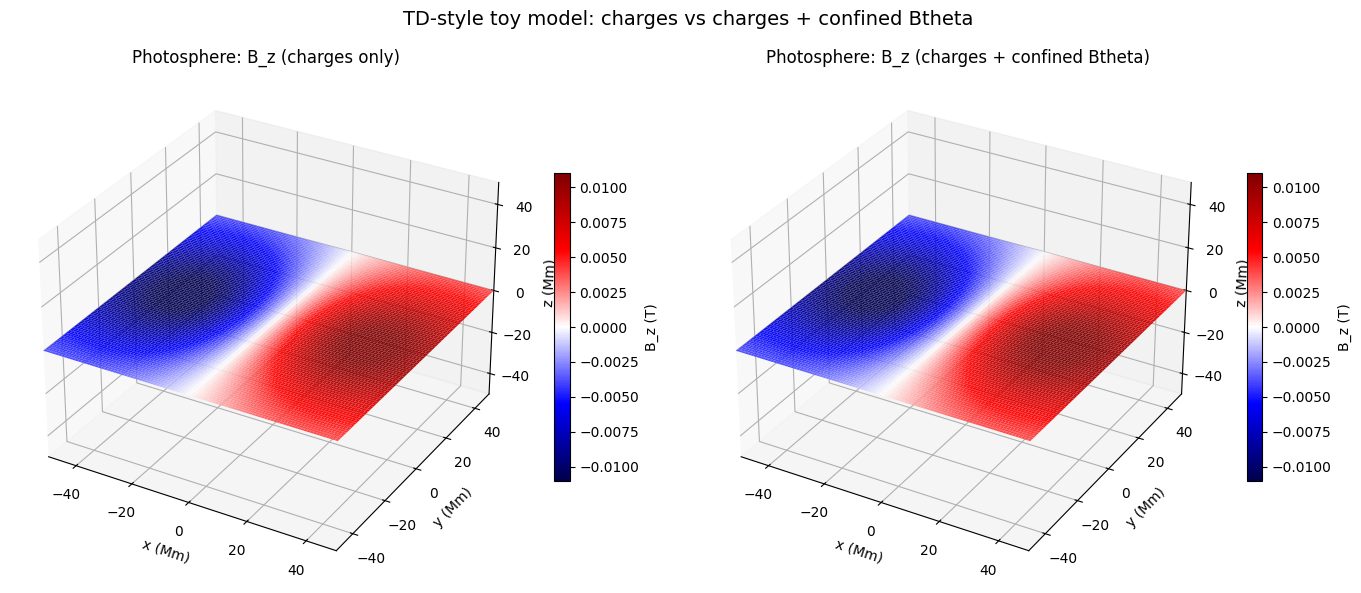

In [10]:
# improved_td_model.py
# Self-contained improved TD-style toy model: Bq (bipole) + confined Btheta (toroidal)
# Author: ChatGPT (edited for Maitri)
# Run with: python improved_td_model.py

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import warnings

# ---------------------------
# USER PARAMETERS (tweak these)
# ---------------------------
Mm = 1e6               # meters per Mm
domain_size_Mm = 100.0 # full cubic domain size in Mm
N = 100                # points per axis (N^3 memory; 100^3 ~ 1e6 points)
L = 30.0               # Mm: half-separation of sub-photospheric bipoles is L/2
d_Mm = 60.0            # Mm: torus center depth (make sure d > R + a)
R_Mm = 20.0            # Mm: major radius of torus
a_Mm = 5.0             # Mm: minor radius (tube radius) of torus
q_Mm2 = 1e2            # source moment in T·Mm^2 (for the dipole charges)
li = 0.5               # internal inductance parameter (used in ring current calc)

# envelope width parameters (controls how rapidly Btheta decays)
rho_envelope_factor = 1.0   # multiply a by this for radial envelope
z_envelope_factor = 2.0     # scale for vertical Gaussian width (in units of a)

# ---------------------------
# quick geometry consistency check (must have torus entirely below photosphere)
# ---------------------------
if d_Mm <= (R_Mm + a_Mm):
    warnings.warn(
        "Torus is too close to the photosphere (d <= R + a). "
        "This will cause strong toroidal field at z=0. Increase d_Mm so d_Mm > R_Mm + a_Mm."
    )

# ---------------------------
# conversion to SI
# ---------------------------
Mm_m = Mm
q = q_Mm2 * (Mm_m**2)   # convert q from T·Mm^2 to T·m^2
R = R_Mm * Mm_m
a = a_Mm * Mm_m
d = d_Mm * Mm_m

# ---------------------------
# Grid in Mm (for plotting) and meters for computation
# ---------------------------
half = domain_size_Mm / 2.0
x_Mm = np.linspace(-half, half, N)
y_Mm = np.linspace(-half, half, N)
z_Mm = np.linspace(-half, half, N)
Xp_Mm, Yp_Mm = np.meshgrid(x_Mm, y_Mm, indexing='xy')  # for photospheric plane plotting

# 3D arrays in meters for physics
xx = x_Mm * Mm_m
yy = y_Mm * Mm_m
zz = z_Mm * Mm_m
X3, Y3, Z3 = np.meshgrid(xx, yy, zz, indexing='xy')  # shape (N,N,N)

# ---------------------------
# Bipolar subphotospheric charges (Bq) - vectorized function
# ---------------------------
eps = 1e-9  # softening (meters)

def compute_B_from_point_charge(q_val, r0, X, Y, Z):
    rx = X - r0[0]
    ry = Y - r0[1]
    rz = Z - r0[2]
    r3 = (rx**2 + ry**2 + rz**2) ** 1.5 + eps
    Bx = q_val * rx / r3
    By = q_val * ry / r3
    Bz = q_val * rz / r3
    return Bx, By, Bz

# charge positions (meters): x = +/- L/2, y=0, z = -d (under photosphere)
xpos = (L/2.0) * Mm_m
negpos = -xpos
ypos = 0.0
zcharge = -d  # torus center at z=-d, put charges at same depth for toy model

r1 = np.array([xpos, ypos, zcharge])
r2 = np.array([negpos, ypos, zcharge])

Bx1, By1, Bz1 = compute_B_from_point_charge(+q, r1, X3, Y3, Z3)
Bx2, By2, Bz2 = compute_B_from_point_charge(-q, r2, X3, Y3, Z3)
Bx_q = Bx1 + Bx2
By_q = By1 + By2
Bz_q = Bz1 + Bz2

# ---------------------------
# Ring-current estimate (I) from your formula (keeps same spirit)
# ---------------------------
mu0 = 4e-7 * np.pi

def compute_ring_current(R_m, a_m, L_m, q_m2, li_val):
    # R_m, a_m, L_m in meters; q_m2 in T·m^2
    numerator = 8 * np.pi * q_m2 * L_m * R_m * (R_m**2 + L_m**2)**(-1.5)
    denominator = mu0 * (np.log(8 * R_m / a_m) - 1.5 + li_val / 2.0)
    return numerator / denominator

I = compute_ring_current(R, a, L * Mm_m, q, li)
# print ring current magnitude for diagnostics
print("Estimated ring current I = {:.3e} A".format(I))

# ---------------------------
# Improved Btheta: confined, smooth envelope around torus tube
# ---------------------------
# Compute cylindrical radial from torus axis using the standard torus coordinate:
# r_perp = sqrt( y^2 + (z + d)^2 )
# rho = sqrt( x^2 + (r_perp - R)^2 )  -> distance from torus tube central circle (i.e., tube radius coordinate)
# e_theta unit vector around torus: (0, -(z + d)/r_perp, y/r_perp)  (same as your earlier code)
#
# We'll compute a physically plausible Btheta magnitude that peaks inside the tube,
# scales with mu0*I/(2*pi*r_perp) as a baseline and is multiplied by a Gaussian envelope
# that depends on distance from the tube axis (rho/a) and vertical offset ((Z + d)/ (z_envelope))
#
# The envelope guarantees Btheta is essentially zero at the photosphere (Z=0) when d >> a.

def compute_Btheta_confined(X, Y, Z, R_m, a_m, d_m, I_val, I0_scale=-0.2, chi=1.0,
                            rho_env_factor=1.0, z_env_factor=2.0):
    # X,Y,Z in meters
    # R_m, a_m, d_m in meters
    # I_val in A
    mu0 = 4e-7 * np.pi

    # cylindrical distance from torus circle centerline
    r_perp = np.sqrt(Y**2 + (Z + d_m)**2)
    # avoid division by zero
    r_perp_safe = np.where(r_perp == 0.0, 1e-12, r_perp)

    # rho: distance to the tube axis (distance from torus circle)
    rho = np.sqrt(X**2 + (r_perp - R_m)**2)

    # e_theta unit vector (azimuth around torus circle)
    e_theta_x = np.zeros_like(X)
    e_theta_y = -(Z + d_m) / r_perp_safe
    e_theta_z = Y / r_perp_safe

    # baseline magnitude (Biot-Savart-like scaling); keep sign consistent with current direction
    # Use an amplitude based on mu0 * I / (2*pi*r_perp) but avoid singularity
    baseline = (mu0 * I_val) / (2.0 * np.pi * r_perp_safe)

    # Smooth envelope: Gaussian in rho normalized by a (radial tube), and Gaussian in vertical offset (Z + d)
    rho_env = rho_env_factor * a_m
    z_env = z_env_factor * a_m

    envelope = np.exp(- (rho / rho_env)**2 ) * np.exp(- ((Z + d_m) / z_env)**2 )

    # inside tube modification: if you want slightly different behaviour inside rho<a, you can increase amplitude
    inside_boost = 1.0 + 0.5 * (rho < a_m)  # small boost inside tube core (optional)

    # final Btheta magnitude
    Btheta_mag = baseline * envelope * inside_boost

    # If you used I0 concept, you can add it as a small correction (kept small or commented)
    # Btheta_mag *= (1.0 + 0.0)  # placeholder

    Bx_t = Btheta_mag * e_theta_x
    By_t = Btheta_mag * e_theta_y
    Bz_t = Btheta_mag * e_theta_z

    return Bx_t, By_t, Bz_t, rho  # return rho for diagnostics/optional masking

# compute Btheta on the grid
Bx_t, By_t, Bz_t, rho_grid = compute_Btheta_confined(
    X3, Y3, Z3,
    R_m=R,
    a_m=a,
    d_m=d,
    I_val=I,
    I0_scale=-0.2,
    chi=1.0,
    rho_env_factor=rho_envelope_factor,
    z_env_factor=z_envelope_factor
)

# ---------------------------
# total field
# ---------------------------
Bx_total = Bx_q + Bx_t
By_total = By_q + By_t
Bz_total = Bz_q + Bz_t

# ---------------------------
# Extract photospheric plane (z = 0)
# ---------------------------
z0_idx = np.argmin(np.abs(z_Mm * Mm_m - 0.0))
Bz_photos_q = Bz_q[:, :, z0_idx]
Bz_photos_total = Bz_total[:, :, z0_idx]
Bx_photos_total = Bx_total[:, :, z0_idx]
By_photos_total = By_total[:, :, z0_idx]

# Quick diagnostics
print("Photospheric Bz (only charges)  min/max:", Bz_photos_q.min(), Bz_photos_q.max())
print("Photospheric Bz (charges+Btheta) min/max:", Bz_photos_total.min(), Bz_photos_total.max())

# Check how suppressed Btheta is at z=0 by computing typical amplitude
# sample Btheta magnitude on z=0:
Bx_t_ph = Bx_t[:, :, z0_idx]
By_t_ph = By_t[:, :, z0_idx]
Btheta_mag_ph = np.sqrt(Bx_t_ph**2 + By_t_ph**2 + Bz_t[:, :, z0_idx]**2)
print("Photospheric Btheta: max, median:", np.max(Btheta_mag_ph), np.median(Btheta_mag_ph))
print("Suppression factor (max Btheta_ph / max Btheta coronal):",
      np.max(Btheta_mag_ph) / (np.max(np.sqrt(Bx_t**2 + By_t**2 + Bz_t**2)) + 1e-30))

# ---------------------------
# Plot photospheric magnetogram (charges-only and charges+Btheta side-by-side)
# ---------------------------
fig = plt.figure(figsize=(14, 6))

# panel 1: Bz from charges only
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
Zplane = np.zeros_like(Xp_Mm)
norm1 = Normalize(vmin=np.percentile(Bz_photos_q, 2), vmax=np.percentile(Bz_photos_q, 98))
cmap = plt.get_cmap('seismic')
facecolors1 = cmap(norm1(Bz_photos_q))
surf1 = ax1.plot_surface(Xp_Mm, Yp_Mm, Zplane, facecolors=facecolors1, rstride=1, cstride=1, linewidth=0, antialiased=True, shade=False, alpha=0.95)
ax1.set_title('Photosphere: B_z (charges only)')
ax1.set_xlabel('x (Mm)'); ax1.set_ylabel('y (Mm)'); ax1.set_zlabel('z (Mm)')
ax1.set_xlim(-half, half); ax1.set_ylim(-half, half); ax1.set_zlim(-half, half)
ax1.view_init(elev=30, azim=-60)

m1 = plt.cm.ScalarMappable(norm=norm1, cmap=cmap)
m1.set_array(Bz_photos_q)
fig.colorbar(m1, ax=ax1, shrink=0.6, pad=0.05).set_label('B_z (T)')

# panel 2: Bz total (charges + confined Btheta)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
norm2 = Normalize(vmin=np.percentile(Bz_photos_total, 2), vmax=np.percentile(Bz_photos_total, 98))
facecolors2 = cmap(norm2(Bz_photos_total))
surf2 = ax2.plot_surface(Xp_Mm, Yp_Mm, Zplane, facecolors=facecolors2, rstride=1, cstride=1, linewidth=0, antialiased=True, shade=False, alpha=0.95)
ax2.set_title('Photosphere: B_z (charges + confined Btheta)')
ax2.set_xlabel('x (Mm)'); ax2.set_ylabel('y (Mm)'); ax2.set_zlabel('z (Mm)')
ax2.set_xlim(-half, half); ax2.set_ylim(-half, half); ax2.set_zlim(-half, half)
ax2.view_init(elev=30, azim=-60)

m2 = plt.cm.ScalarMappable(norm=norm2, cmap=cmap)
m2.set_array(Bz_photos_total)
fig.colorbar(m2, ax=ax2, shrink=0.6, pad=0.05).set_label('B_z (T)')

plt.suptitle('TD-style toy model: charges vs charges + confined Btheta', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ---------------------------
# OPTIONAL: Save small diagnostic arrays or images
# ---------------------------
# np.savez_compressed("td_photosphere_diagnostics.npz",
#                     x_Mm=x_Mm, y_Mm=y_Mm,
#                     Bz_photos_q=Bz_photos_q,
#                     Bz_photos_total=Bz_photos_total,
#                     Btheta_ph=Btheta_mag_ph)

# End of script
